In [1]:
# training a model using all possible features
# questions arises if we should encode before or after splitting the data
# after some research on the internet, most recommend doing the encoding on the training data, and 
# repeating the steps on for the test data
# most exercises on kaggle did the encoding on the whole dataset, then split it
# I think there is a possibility of data leackage when encoding on the whole data set!
# usind data preperation as in the pytorch example

In [2]:
# reading the data ml-latest-small
import pandas as pd
import zipfile
import numpy as np 
zf = zipfile.ZipFile('/home/elena/Downloads/ml-latest-small.zip')
# reading ratings file:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(zf.open('ml-latest-small/ratings.csv'), names=r_cols)
m_cols=['movie_id', 'title', 'genre']
movies = pd.read_csv(zf.open('ml-latest-small/movies.csv'), names=m_cols)
# merging ratings and movies
data=pd.merge(ratings,movies,on='movie_id')

In [3]:
zz = zipfile.ZipFile('/home/elena/Downloads/ml-100k.zip')
# reading users file:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(zz.open('ml-100k/u.user'), sep='|', names=u_cols,encoding='latin-1')
data=pd.merge(users,data, on='user_id')
data.head()

,user_id,age,sex,occupation,zip_code,movie_id,rating,unix_timestamp,title,genre
0,1,24,M,technician,85711,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,24,M,technician,85711,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,24,M,technician,85711,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,24,M,technician,85711,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,24,M,technician,85711,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [4]:
cat_features=['sex','occupation','zip_code','genre' ]
num_features=['user_id','age','movie_id','rating','unix_timestamp','movie_index']
data.dtypes
# we can remove title when training the model, since it will not effect the outcome; it's just a name 
# assigned to each movie_id

user_id             int64
age                 int64
sex                object
occupation         object
zip_code           object
movie_id            int64
rating            float64
unix_timestamp      int64
title              object
genre              object
dtype: object

In [5]:
unique_movies=data.movie_id.unique()
unique_movies.min(),unique_movies.max(), len(unique_movies)
# movie_id's are numbers, but they have a bigger range then the actual amount of unique movies!
# lets start with indexing the movie_id

(1, 193609, 9724)

In [6]:
unique_movies = data.movie_id.unique() # returns a np array
movie_to_index = {old: new for new, old in enumerate(unique_movies)} # indexing movie_id, tart at 0
index_to_movie = {idx: movie for movie, idx in movie_to_index.items()}
new_movies = data.movie_id.map(movie_to_index) # replaces movie_id with coresp. index
data['movie_index']=new_movies
data.head()

,user_id,age,sex,occupation,zip_code,movie_id,rating,unix_timestamp,title,genre,movie_index
0,1,24,M,technician,85711,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0
1,1,24,M,technician,85711,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,1
2,1,24,M,technician,85711,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,2
3,1,24,M,technician,85711,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,3
4,1,24,M,technician,85711,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4


In [11]:
# to be sure that we have done it right, lets compare
compare_data=data[['user_id', 'movie_id', 'movie_index','rating']]
compare_data['old_movie_id']=compare_data.movie_index.map(index_to_movie)
compare_data.tail() # looks good

,user_id,movie_id,movie_index,rating,old_movie_id
100831,610,160341,9719,2.5,160341
100832,610,160527,9720,4.5,160527
100833,610,160836,9721,3.0,160836
100834,610,163937,9722,3.5,163937
100835,610,163981,9723,3.5,163981


In [12]:
data.user_id.unique().shape[0], data.user_id.min(), data.user_id.max(), 
# we have as many users as we have id's for them

(610, 1, 610)

In [13]:
data.occupation.unique().shape[0], data.zip_code.unique().shape[0], data.genre.unique().shape[0]

(21, 541, 951)

In [14]:
# we have several categorical features; 'sex','occupation','zip_code','genre'
# age is the only numerical feature where the number has a 'meaning'
# there a 2 ways how to handle cat. features: encoding (different ways to do so) and embeddings
#  first approach will be to use embeddings
# note: 1 embedding layer is required for each categorical feature, and the embedding expects the 
# categories to be ordinal encoded, although no relationship between the categories is assumed 
# (statement from kaggle)

In [7]:
# splitting into train and test data
# data was split and safed! 
train=pd.read_pickle('/home/elena/Downloads/traindata.pkl')
test=pd.read_pickle('/home/elena/Downloads/testdata.pkl')

In [8]:
# we need to add movie_index to train and test data
train['movie_index']=train.movie_id.map(movie_to_index)
test['movie_index']=test.movie_id.map(movie_to_index)

In [17]:
train.head()

,user_id,age,sex,occupation,zip_code,movie_id,rating,unix_timestamp,title,genre,movie_index
97717,606,28,M,programmer,63044,3462,4.0,1171501099,Modern Times (1936),Comedy|Drama|Romance,1185
100124,610,22,M,student,21227,8914,4.0,1493845360,Primer (2004),Drama|Sci-Fi,2266
25952,180,22,F,administrator,60202,1196,4.0,1270237862,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,68
25871,178,26,M,other,49512,2231,4.5,1163673637,Rounders (1998),Drama,2183
97255,605,33,M,engineer,33716,1588,4.0,1277094877,George of the Jungle (1997),Children|Comedy,1495


In [18]:
movie_to_index[8914]

2266

In [9]:
y_train=train.rating
y_test=test.rating
X_train=train.drop('rating',axis=1)
X_test=test.drop('rating', axis=1)

In [20]:
X_train.shape

(75627, 10)

In [10]:
# Encoding and getting data ready
from sklearn.preprocessing import LabelEncoder
# 1. approach: we fit on the training data, and transform the encoding to train and test datat 
# we got an error, because e.g. we have genre which are in test data but not in train!
# thus, we use encoding seperately
# Make copy to avoid changing original data 
X_train_label = X_train.copy()
X_test_label = X_test.copy()

cat_features=['unix_timestamp','sex','occupation','zip_code','genre']
# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in cat_features:
    X_train_label[col+'_label'] = label_encoder.fit_transform(X_train[col])
    X_test_label[col+'_label'] = label_encoder.fit_transform(X_test[col])

In [23]:
X_train_label.head()

,user_id,age,sex,occupation,zip_code,movie_id,unix_timestamp,title,genre,movie_index,unix_timestamp_label,sex_label,occupation_label,zip_code_label,genre_label
97717,606,28,M,programmer,63044,3462,1171501099,Modern Times (1936),Comedy|Drama|Romance,1185,25146,1,14,342,661
100124,610,22,M,student,21227,8914,1493845360,Primer (2004),Drama|Sci-Fi,2266,56337,1,18,138,842
25952,180,22,F,administrator,60202,1196,1270237862,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,68,36514,0,0,325,120
25871,178,26,M,other,49512,2231,1163673637,Rounders (1998),Drama,2183,23751,1,13,257,779
97255,605,33,M,engineer,33716,1588,1277094877,George of the Jungle (1997),Children|Comedy,1495,36920,1,4,198,574


In [11]:
# Implementation 
from keras.layers import Input, Embedding, Concatenate, Flatten, Dense, Dot, Add, Multiply, Subtract, Average, Reshape
from keras.models import Model
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [69]:
# all features as embedding inputs

In [26]:
X_train_label.sex_label.max(), X_test_label.sex_label.max(),
X_train_label.occupation_label.max(), X_test_label.occupation_label.max(),
X_train_label.zip_code_label.max(), X_test_label.zip_code_label.max(),
X_train_label.genre_label.max(), X_test_label.genre_label.max() # difference !

(915, 761)

In [27]:
def embedding_model(hidden_units, embedding_dim, merging_method):
    # Each instance will consist of 7 inputs:
    # col_embedding=['user_id', 'movie_index', 'unix_timestamp', 'sex_label', 'occupation_label', 'zip_code_label', 'genre_label']

    user_id_input = Input(shape=(1,), name='user_id')
    movie_index_input = Input(shape=(1,), name='movie_index')
    unix_timestamp_input = Input(shape=(1,), name='unix_timestamp')
    sex_input = Input(shape=(1,), name='sex')
    occupation_input=Input(shape=(1,), name='occupation')
    zip_code_input=Input(shape=(1,), name='zip_code')
    genre_input=Input(shape=(1,), name='genre')

    # Embeddings
    user_embedded = Embedding(data.movie_id.max()+1, embedding_dim, 
                                       input_length=1, name='user_embedding')(user_id_input)
    movie_embedded = Embedding(data.movie_index.max()+1, embedding_dim, 
                                        input_length=1, name='movie_embedding')(movie_index_input)
    unix_timestamp_embedded = Embedding(X_train_label.unix_timestamp_label.max()+1, embedding_dim, 
                                        input_length=1, name='unix_timestamp_embedding')(unix_timestamp_input)
    sex_embedded = Embedding(X_train_label.sex_label.max()+1, embedding_dim, 
                                        input_length=1, name='sex_embedding')(sex_input)
    occupation_embedded= Embedding(X_train_label.occupation_label.max()+1, embedding_dim, 
                                        input_length=1, name='occupation_embedding')(occupation_input)
    zipe_code_embedded = Embedding(X_train_label.zip_code_label.max()+1, embedding_dim, 
                                        input_length=1, name='zip_code_embedding')(zip_code_input)
    genre_embedded = Embedding(X_train_label.genre_label.max()+1, embedding_dim, 
                                        input_length=1, name='genre_embedding')(genre_input)
    # merging the embeddings
    embeddings_cols=[user_embedded, movie_embedded,  unix_timestamp_embedded, zipe_code_embedded, occupation_embedded, genre_embedded]

    if merging_method=='concatenate':
        merged = Concatenate()(embeddings_cols)
    if merging_method=='dot_product':
        merged =Dot(name = 'dot_product', normalize = True, axes = 2)(embeddings_cols)
    if merging_method=='add':
        merged =Add()(embeddings_cols)
    if merging_method=='substract':
        merged=Subtract()(embeddings_cols)
    if merging_method=='multiply':
        merged=Multiply()(embeddings_cols)
    if merging_method=='average':
        merged=Average()(embeddings_cols)
    out = Flatten()(merged)

    # Add one or more hidden layers
    for n_hidden in hidden_units:
        out = Dense(n_hidden, activation='relu')(out)

    # A single output: our predicted rating
    out = Dense(1, activation='linear', name='prediction')(out)
    model=Model(inputs = [user_id_input, movie_index_input, unix_timestamp_input, sex_input, occupation_input, zip_code_input, genre_input],outputs = out)
    model.compile(optimizer = 'Adam',loss='MSE',metrics=['MAE'])
    return model

In [29]:
hidden_units = (100,50) #same as in pytorch model
embedding_dim = 50 #same as in pytorch model
es=EarlyStopping(monitor='val_MAE', min_delta=0, patience=0, verbose=0, mode='min', baseline=None, restore_best_weights=False)
# col_embedding=['user_id', 'movie_index', 'unix_timestamp', 'sex_label', 'occupation_label', #'zip_code_label', 'genre_label']

inputs=[X_train_label.user_id,X_train_label.movie_index,X_train_label.unix_timestamp_label,X_train_label.sex_label, X_train_label.occupation_label, X_train_label.zip_code_label, X_train_label.genre_label]
inputs_test=[X_test_label.user_id,X_test_label.movie_index,X_test_label.unix_timestamp_label,X_test_label.sex_label, X_test_label.occupation_label, X_test_label.zip_code_label, X_test_label.genre_label]

In [30]:
model_concatenate=embedding_model(hidden_units,embedding_dim, merging_method='concatenate')
#model_concatenate.summary(line_length=88)

In [31]:
history= model_concatenate.fit(x=inputs, y=y_train, batch_size=500,epochs=10, verbose=2, validation_data=[inputs_test,y_test], callbacks=[es])

Train on 75627 samples, validate on 25209 samples
Epoch 1/10
 - 60s - loss: 2.5895 - MAE: 1.1563 - val_loss: 0.8839 - val_MAE: 0.7453
Epoch 2/10
 - 59s - loss: 0.5682 - MAE: 0.5643 - val_loss: 1.1799 - val_MAE: 0.8625


In [32]:
# 58s - loss: 0.5755 - MAE: 0.5678 - val_loss: 1.2143 - val_MAE: 0.8771

In [33]:
val_MAE_concat=history.history['val_MAE']
MAE_concat=history.history['MAE']
loss_concat=history.history['loss']
val_loss_concat=history.history['val_loss']
epoch_concat=history.epoch

In [34]:
model_add=embedding_model(hidden_units,embedding_dim, merging_method='add')
history= model_add.fit(x=inputs, y=y_train, batch_size=500,epochs=10, verbose=2, validation_data=[inputs_test,y_test], callbacks=[es])

Train on 75627 samples, validate on 25209 samples
Epoch 1/10
 - 58s - loss: 2.6370 - MAE: 1.1689 - val_loss: 0.9445 - val_MAE: 0.7742
Epoch 2/10
 - 60s - loss: 0.5721 - MAE: 0.5632 - val_loss: 1.0034 - val_MAE: 0.7918


In [36]:
# - 57s - loss: 0.5650 - MAE: 0.5582 - val_loss: 1.0178 - val_MAE: 0.7992

In [35]:
val_MAE_add=history.history['val_MAE']
MAE_add=history.history['MAE']
loss_add=history.history['loss']
val_loss_add=history.history['val_loss']
epoch_add=history.epoch

In [37]:
model_multiply=embedding_model(hidden_units,embedding_dim, merging_method='multiply')
history= model_multiply.fit(x=inputs, y=y_train, batch_size=500,epochs=10, verbose=2, validation_data=[inputs_test,y_test], callbacks=[es])

Train on 75627 samples, validate on 25209 samples
Epoch 1/10
 - 60s - loss: 4.7093 - MAE: 1.7269 - val_loss: 1.0821 - val_MAE: 0.8243
Epoch 2/10
 - 61s - loss: 1.0886 - MAE: 0.8295 - val_loss: 1.0825 - val_MAE: 0.8264


In [38]:
#  59s - loss: 1.0887 - MAE: 0.8293 - val_loss: 1.0825 - val_MAE: 0.8262

In [39]:
val_MAE_mult=history.history['val_MAE']
MAE_mult=history.history['MAE']
loss_mult=history.history['loss']
val_loss_mult=history.history['val_loss']
epoch_mult=history.epoch

In [40]:
model_average=embedding_model(hidden_units,embedding_dim, merging_method='average')
history= model_average.fit(x=inputs, y=y_train, batch_size=500,epochs=10, verbose=2, validation_data=[inputs_test,y_test], callbacks=[es])

Train on 75627 samples, validate on 25209 samples
Epoch 1/10
 - 61s - loss: 3.2243 - MAE: 1.3125 - val_loss: 0.8741 - val_MAE: 0.7411
Epoch 2/10
 - 59s - loss: 0.6401 - MAE: 0.6014 - val_loss: 0.8858 - val_MAE: 0.7422


In [41]:
val_MAE_av=history.history['val_MAE']
MAE_av=history.history['MAE']
loss_av=history.history['loss']
val_loss_av=history.history['val_loss']
epoch_av=history.epoch

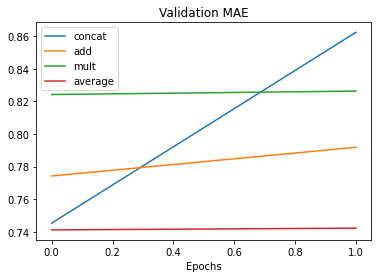

In [42]:
# comparing the models
import matplotlib.pyplot as plt 
plt.plot(epoch_concat, val_MAE_concat, label='concat')
plt.plot(epoch_add, val_MAE_add, label='add')
plt.plot(epoch_mult, val_MAE_mult, label='mult')
plt.plot(epoch_av, val_MAE_av, label='average')
plt.xlabel('Epochs')
plt.title('Validation MAE')
plt.legend() 
plt.show() 

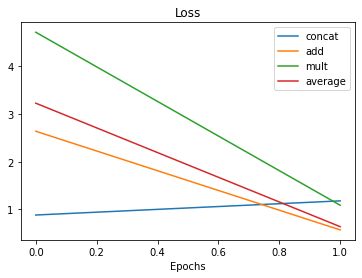

In [44]:
plt.plot(epoch_concat, val_loss_concat, label='concat')
plt.plot(epoch_add, loss_add, label='add')
plt.plot(epoch_mult, loss_mult, label='mult')
plt.plot(epoch_av, loss_av, label='average')
plt.xlabel('Epochs')
plt.title('Loss')
plt.legend() 
plt.show()  

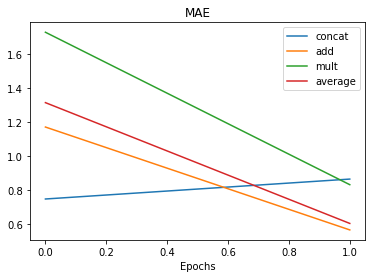

In [43]:
plt.plot(epoch_concat, val_MAE_concat, label='concat')
plt.plot(epoch_add, MAE_add, label='add')
plt.plot(epoch_mult, MAE_mult, label='mult')
plt.plot(epoch_av, MAE_av, label='average')
plt.xlabel('Epochs')
plt.title('MAE')
plt.legend() 
plt.show()  

In [ ]:
# model_average turns out to be the best

In [45]:
# to better compare the above models with the ones where only user and movies are used as inputs, we 
# should fit the encoding to the whole data and then transform it on train and test, since we did that # with the indexing of the movie_id

In [12]:
X_train_l = X_train.copy()
X_test_l = X_test.copy()

cat_features=['unix_timestamp','sex','occupation','zip_code','genre']
# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in cat_features:
    label_encoder.fit(data[col])
    X_train_l[col+'_label'] = label_encoder.transform(X_train[col])
    X_test_l[col+'_label'] = label_encoder.transform(X_test[col])

In [23]:
X_train_l.head()

,user_id,age,sex,occupation,zip_code,movie_id,unix_timestamp,title,genre,movie_index,unix_timestamp_label,sex_label,occupation_label,zip_code_label,genre_label
97717,606,28,M,programmer,63044,3462,1171501099,Modern Times (1936),Comedy|Drama|Romance,1185,31422,1,14,342,687
100124,610,22,M,student,21227,8914,1493845360,Primer (2004),Drama|Sci-Fi,2266,72974,1,18,138,876
25952,180,22,F,administrator,60202,1196,1270237862,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,68,46607,0,0,325,127
25871,178,26,M,other,49512,2231,1163673637,Rounders (1998),Drama,2183,29553,1,13,257,812
97255,605,33,M,engineer,33716,1588,1277094877,George of the Jungle (1997),Children|Comedy,1495,47137,1,4,198,595


In [24]:
def embedding_model_l(hidden_units, embedding_dim, merging_method):
    # Each instance will consist of 7 inputs:
    # col_embedding=['user_id', 'movie_index', 'unix_timestamp', 'sex_label', 'occupation_label', 'zip_code_label', 'genre_label']

    user_id_input = Input(shape=(1,), name='user_id')
    movie_index_input = Input(shape=(1,), name='movie_index')
    unix_timestamp_input = Input(shape=(1,), name='unix_timestamp')
    sex_input = Input(shape=(1,), name='sex')
    occupation_input=Input(shape=(1,), name='occupation')
    zip_code_input=Input(shape=(1,), name='zip_code')
    genre_input=Input(shape=(1,), name='genre')

    # Embeddings
    user_embedded = Embedding(data.movie_id.max()+1, embedding_dim, 
                                       input_length=1, name='user_embedding')(user_id_input)
    movie_embedded = Embedding(data.movie_index.max()+1, embedding_dim, 
                                        input_length=1, name='movie_embedding')(movie_index_input)
    unix_timestamp_embedded = Embedding(max(X_train_l.unix_timestamp_label.max(),X_test_l.unix_timestamp_label.max())+1, embedding_dim, 
                                        input_length=1, name='unix_timestamp_embedding')(unix_timestamp_input)
    sex_embedded = Embedding(X_train_l.sex_label.max()+1, embedding_dim, 
                                        input_length=1, name='sex_embedding')(sex_input)
    occupation_embedded= Embedding(max(X_train_l.occupation_label.max(),X_test_l.occupation_label.max())+1, embedding_dim, 
                                        input_length=1, name='occupation_embedding')(occupation_input)
    zipe_code_embedded = Embedding(max(X_train_l.zip_code_label.max(),X_test_l.zip_code_label.max())+1, embedding_dim, 
                                        input_length=1, name='zip_code_embedding')(zip_code_input)
    genre_embedded = Embedding(max(X_train_l.genre_label.max(),X_test_l.genre_label.max())+1, embedding_dim, 
                                        input_length=1, name='genre_embedding')(genre_input)
    # merging the embeddings
    embeddings_cols=[user_embedded, movie_embedded,  unix_timestamp_embedded, zipe_code_embedded, occupation_embedded, genre_embedded]

    if merging_method=='concatenate':
        merged = Concatenate()(embeddings_cols)
    if merging_method=='dot_product':
        merged =Dot(name = 'dot_product', normalize = True, axes = 2)(embeddings_cols)
    if merging_method=='add':
        merged =Add()(embeddings_cols)
    if merging_method=='substract':
        merged=Subtract()(embeddings_cols)
    if merging_method=='multiply':
        merged=Multiply()(embeddings_cols)
    if merging_method=='average':
        merged=Average()(embeddings_cols)
    out = Flatten()(merged)

    # Add one or more hidden layers
    for n_hidden in hidden_units:
        out = Dense(n_hidden, activation='relu')(out)

    # A single output: our predicted rating
    out = Dense(1, activation='linear', name='prediction')(out)
    model=Model(inputs = [user_id_input, movie_index_input, unix_timestamp_input, sex_input, occupation_input, zip_code_input, genre_input],outputs = out)
    model.compile(optimizer = 'Adam',loss='MSE',metrics=['MAE'])
    return model

In [25]:
inputs=[X_train_l.user_id,X_train_l.movie_index,X_train_l.unix_timestamp_label,X_train_l.sex_label, X_train_l.occupation_label, X_train_l.zip_code_label, X_train_l.genre_label]
inputs_test=[X_test_l.user_id,X_test_l.movie_index,X_test_l.unix_timestamp_label,X_test_l.sex_label, X_test_l.occupation_label, X_test_l.zip_code_label, X_test_l.genre_label]
hidden_units = (100,50) #same as in pytorch model
embedding_dim = 50 #same as in pytorch model
es=EarlyStopping(monitor='val_MAE', min_delta=0, patience=0, verbose=0, mode='min', baseline=None, restore_best_weights=False)

In [26]:
model_concatenate_l=embedding_model_l((100,50), 50, merging_method='concatenate')
history= model_concatenate_l.fit(x=inputs, y=y_train, batch_size=500,epochs=10, verbose=2, validation_data=[inputs_test,y_test], callbacks=[es])

Train on 75627 samples, validate on 25209 samples
Epoch 1/10
 - 122s - loss: 2.5695 - MAE: 1.1501 - val_loss: 0.7661 - val_MAE: 0.6729
Epoch 2/10
 - 121s - loss: 0.5718 - MAE: 0.5641 - val_loss: 0.8271 - val_MAE: 0.7050


In [57]:
model_concatenate_l.summary(line_length=88)

Model: "model_4"
________________________________________________________________________________________
Layer (type)                 Output Shape       Param #   Connected to                  
user_id (InputLayer)         (None, 1)          0                                       
________________________________________________________________________________________
movie_index (InputLayer)     (None, 1)          0                                       
________________________________________________________________________________________
unix_timestamp (InputLayer)  (None, 1)          0                                       
________________________________________________________________________________________
zip_code (InputLayer)        (None, 1)          0                                       
________________________________________________________________________________________
occupation (InputLayer)      (None, 1)          0                                       
____

In [37]:
#- 59s - loss: 0.5682 - MAE: 0.5643 - val_loss: 1.1799 - val_MAE: 0.8625

In [27]:
val_MAE_concat_l=history.history['val_MAE']
MAE_concat_l=history.history['MAE']
loss_concat=history.history['loss']
val_loss_concat_l=history.history['val_loss']
epoch_concat_l=history.epoch

In [30]:
model_add_l=embedding_model_l((100,50), 50, merging_method='add')
history= model_add_l.fit(x=inputs, y=y_train, batch_size=500,epochs=10, verbose=2, validation_data=[inputs_test,y_test], callbacks=[es])

Train on 75627 samples, validate on 25209 samples
Epoch 1/10
 - 117s - loss: 2.5865 - MAE: 1.1591 - val_loss: 0.7749 - val_MAE: 0.6787
Epoch 2/10
 - 118s - loss: 0.5682 - MAE: 0.5604 - val_loss: 0.7865 - val_MAE: 0.6849


In [ ]:
#  60s - loss: 0.5721 - MAE: 0.5632 - val_loss: 1.0034 - val_MAE: 0.7918

In [31]:
val_MAE_add_l=history.history['val_MAE']
MAE_add_l=history.history['MAE']
loss_add=history.history['loss']
val_loss_ad_l=history.history['val_loss']
epoch_ad_l=history.epoch

In [32]:
model_mult_l=embedding_model_l((100,50), 50, merging_method='multiply')
history= model_mult_l.fit(x=inputs, y=y_train, batch_size=500,epochs=10, verbose=2, validation_data=[inputs_test,y_test], callbacks=[es])

Train on 75627 samples, validate on 25209 samples
Epoch 1/10
 - 114s - loss: 4.5109 - MAE: 1.6803 - val_loss: 1.0821 - val_MAE: 0.8239
Epoch 2/10
 - 113s - loss: 1.0886 - MAE: 0.8289 - val_loss: 1.0823 - val_MAE: 0.8252


In [ ]:
#  - 61s - loss: 1.0886 - MAE: 0.8295 - val_loss: 1.0825 - val_MAE: 0.8264

In [33]:
val_MAE_mult_l=history.history['val_MAE']
MAE_mult_l=history.history['MAE']
loss_mult=history.history['loss']
val_loss_mult_l=history.history['val_loss']
epoch_mult_l=history.epoch

In [34]:
model_average_l=embedding_model_l((100,50), 50, merging_method='average')
history= model_average_l.fit(x=inputs, y=y_train, batch_size=500,epochs=10, verbose=2, validation_data=[inputs_test,y_test], callbacks=[es])

Train on 75627 samples, validate on 25209 samples
Epoch 1/10
 - 65s - loss: 3.1799 - MAE: 1.3025 - val_loss: 0.7709 - val_MAE: 0.6755
Epoch 2/10
 - 65s - loss: 0.6386 - MAE: 0.6006 - val_loss: 0.7526 - val_MAE: 0.6689
Epoch 3/10
 - 66s - loss: 0.4528 - MAE: 0.4809 - val_loss: 0.7817 - val_MAE: 0.6812


In [ ]:
 #- 59s - loss: 0.6401 - MAE: 0.6014 - val_loss: 0.8858 - val_MAE: 0.7422

In [35]:
val_MAE_av_l=history.history['val_MAE']
MAE_av_l=history.history['MAE']
loss_av=history.history['loss']
val_loss_av_l=history.history['val_loss']
epoch_av_l=history.epoch

In [38]:
# as suspected, we get better results

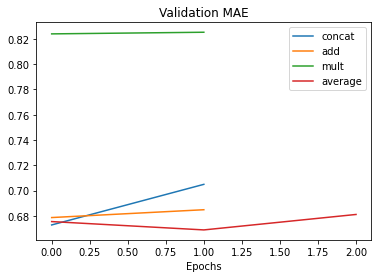

In [39]:
# comparing the models
import matplotlib.pyplot as plt 
plt.plot(epoch_concat_l, val_MAE_concat_l, label='concat')
plt.plot(epoch_ad_l, val_MAE_add_l, label='add')
plt.plot(epoch_mult_l, val_MAE_mult_l, label='mult')
plt.plot(epoch_av_l, val_MAE_av_l, label='average')
plt.xlabel('Epochs')
plt.title('Validation MAE')
plt.legend() 
plt.show() 

In [40]:
# average best

In [42]:
X_test_l.head()

,user_id,age,sex,occupation,zip_code,movie_id,unix_timestamp,title,genre,movie_index,unix_timestamp_label,sex_label,occupation_label,zip_code_label,genre_label
67037,432,22,M,entertainment,50311,33158,1315242713,xXx: State of the Union (2005),Action|Crime|Thriller,5916,49183,1,5,263,260
42175,288,34,M,marketing,23226,1275,976138271,Highlander (1986),Action|Adventure|Fantasy,86,9297,1,11,155,106
93850,599,22,F,student,R3T5K,2501,1498515345,October Sky (1999),Drama,2470,75839,0,18,535,812
6187,42,30,M,administrator,17870,2311,996259554,2010: The Year We Make Contact (1984),Sci-Fi,2151,10700,1,0,106,944
12229,75,24,M,entertainment,08816,5445,1158967067,Minority Report (2002),Action|Crime|Mystery|Sci-Fi|Thriller,758,28275,1,5,60,254


In [47]:
# example prediction
uid=1
# predicting for movies from the test data
movies_test=X_test_l.movie_index[X_test_l.user_id==uid] # index = movie_index rated by user uid
# prediction 

In [53]:
movies_test.shape, movies_test.unique().shape[0], len(movies_test)

((46,), 46, 46)

In [55]:
len(movies_test.index)

46

In [60]:
X_test_uid=X_test_l[X_test_l.user_id==uid]

In [61]:
inputs_user1=[[uid]*len(movies_test), movies_test,X_test_uid.unix_timestamp_label,X_test_uid.sex_label, X_test_uid.occupation_label, X_test_uid.zip_code_label, X_test_uid.genre_label]

In [63]:
pred_concatenate=model_concatenate_l.predict(inputs_user1)
pred_add=model_add_l.predict(inputs_user1)
pred_multiply=model_mult_l.predict(inputs_user1)
pred_average=model_average_l.predict(inputs_user1)

In [64]:
predictions=pd.DataFrame(movies_test.values)
predictions.columns=['movie_index']
predictions['model_concatenate']=pred_concatenate
predictions['model_add']=pred_add
predictions['model_multiply']=pred_multiply
predictions['model_average']=pred_average
predictions

,movie_index,model_concatenate,model_add,model_multiply,model_average
0,226,4.189570,4.445685,3.493914,4.451683
1,149,4.284996,4.167566,3.493914,4.214355
2,87,3.691902,4.390176,3.493914,4.054671
3,35,4.533942,4.771152,3.493914,4.704999
4,134,4.005846,4.150573,3.493914,4.309154
5,164,4.066772,4.427970,3.493914,4.128827
6,114,4.252104,4.525228,3.493914,4.451015
7,127,4.835720,4.966077,3.493914,5.062619
8,199,5.065050,5.260787,3.493914,4.863483
9,186,3.284588,3.884286,3.493914,3.171499


In [65]:
top5_model_concatenate=predictions.nlargest(5,'model_concatenate').movie_index
top5_model_add=predictions.nlargest(5,'model_add').movie_index
top5_model_multiply=predictions.nlargest(5,'model_multiply').movie_index
top5_model_average=predictions.nlargest(5,'model_average').movie_index

df=pd.DataFrame({'top5_model_concatenate': top5_model_concatenate.values, 'top5_model_add':  top5_model_add.values, 'top5_model_mulitply': top5_model_multiply.values, 'top5_model_average': top5_model_average.values})

In [66]:
df

,top5_model_concatenate,top5_model_add,top5_model_mulitply,top5_model_average
0,75,199,226,70
1,199,137,149,127
2,137,75,87,199
3,124,127,35,75
4,147,124,134,147


In [67]:
# 75, 199 are in 3 out of 4 models

In [68]:
movie_name=lambda movie: data.title[data.movie_index==movie]
movie_name(75).unique(), movie_name(199).unique()

(array(['Alien (1979)'], dtype=object),
 array(['Robin Hood (1973)'], dtype=object))